# 파이토치 MNIST 모델

## modules import 

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

## 전처리 설정
- `transform.Compose`

In [10]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, ), (0.5, ))])


## 데이터 로드 및 데이터 확인

In [15]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [18]:
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

test_loader = DataLoader(trainset, batch_size=128, shuffle=False, num_workers=2)

In [19]:
image, label = next(iter(train_loader))

In [20]:
image.shape, label.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [87]:
def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    fig = plt.figure(figsize=(10, 5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

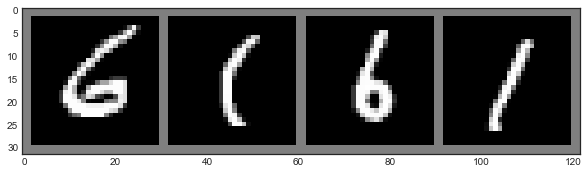

In [88]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[:4]))

## 신경망 구성

In [108]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)           # 6*6 의 의미? 아니고 5*5로 해야 됨 왜??? : 28*28에서 3*3 conv. 2번, 2*2 maxpool 2번 하고나면 5*5 됨
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        print("x__size :", x.size())
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]                             # 왜 size()[0]은 제외함? batch size가 들어가는 자리라서.
        num_features = 1
        for s in size:
            num_features *= s

        return num_features

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


- `.parameters()` 

In [103]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 3, 3])


임의의 값을 넣어 forward값 확인

In [109]:
input = torch.randn(128, 1, 28, 28)
out = net(input)
print(out)

x__size : torch.Size([128, 400])
tensor([[-0.0178, -0.0131, -0.1152,  ...,  0.0819,  0.0149,  0.0140],
        [-0.0127, -0.0317, -0.1053,  ...,  0.0737,  0.0277,  0.0066],
        [-0.0544, -0.0184, -0.0844,  ...,  0.0684,  0.0217, -0.0138],
        ...,
        [-0.0422, -0.0277, -0.0813,  ...,  0.0800,  0.0058, -0.0191],
        [-0.0227, -0.0319, -0.1054,  ...,  0.0697, -0.0050,  0.0009],
        [-0.0133, -0.0160, -0.0899,  ...,  0.0782,  0.0155,  0.0086]],
       grad_fn=<AddmmBackward0>)


## 손실함수와 옵티마이저

## 모델 학습

- `optimizer.zero_grad` : 가중치의 그래디언트 초기화

- loss 계산

- `loss.backward()`

- `optmizer.step()` : 업데이트

- 배치수 확인

- 설명을 위해 `epochs=2`로 지정

## 모델의 저장 및 로드

- `torch.save`
  - `net.state_dict()`를 저장

- `torch.load`
  - `load_state_dict`로 모델을 로드

## 모델 테스트

## GPU 설정 후 학습
- 설정 후, 모델과 데이터에 `to`로 GPU를 사용 가능한 형태로 변환 해줘야 한다.

- `.cuda()` 로도 가능

- 현재 GPU 설정

- 데이터 로드


- 모델 생성